# PreTrain

In [2]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 7

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.429
[2] loss: 0.437
[3] loss: 0.280
[4] loss: 0.198
[5] loss: 0.078
[6] loss: 0.029
[7] loss: 0.015
[8] loss: 0.013
[9] loss: 0.010
[10] loss: 0.007
[11] loss: 0.007
[12] loss: 0.007
[13] loss: 0.006
[14] loss: 0.005
[15] loss: 0.005
[16] loss: 0.002
[17] loss: 0.005
[18] loss: 0.004
[19] loss: 0.004
[20] loss: 0.002


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 7])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

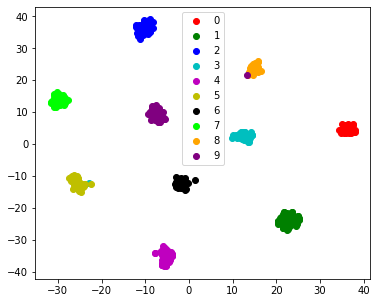

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

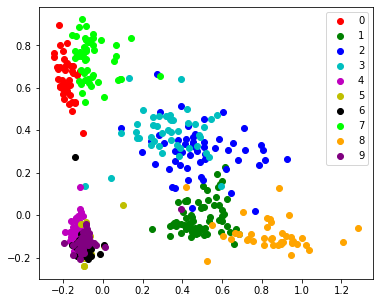

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.1685,  0.4911,  0.4854,  0.3291, -0.1326, -0.0890, -0.1013, -0.0729,
          0.8618, -0.0980],
        [-0.2793,  0.1846,  0.3315, -0.1905,  0.4350, -0.2524,  0.1638, -0.0585,
         -0.2481, -0.2236],
        [ 0.5924, -0.0163,  0.2767,  0.3717, -0.0587, -0.1530, -0.1496,  0.7197,
         -0.1138, -0.1277],
        [-0.1696, -0.0908,  0.3124,  0.3236, -0.2048,  0.6404,  0.0830,  0.2896,
         -0.1162, -0.1054],
        [-0.1777,  0.4733,  0.1143, -0.1931, -0.1578, -0.1682, -0.1535,  0.4464,
         -0.1996,  0.4228],
        [ 0.5193, -0.0642,  0.6111, -0.1511, -0.1983,  0.0443,  0.3990, -0.1568,
         -0.0526, -0.1005],
        [ 0.1238,  0.4122, -0.0982,  0.4210, -0.1254, -0.0565,  0.3544, -0.0578,
         -0.1085, -0.0807]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [15]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [4]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_17.cfg')

['./config/sswae_dev2_1_17.cfg']

In [5]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 3
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 7
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.433768e-01  D: 6.912646e-01  D2: 3.527152e-02  D3: 4.301295e-03
test loss: 1.811894e-01  D: 6.926429e-01  D2: 1.512402e-02  D3: 8.176601e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.694988e-01  D: 6.959277e-01  D2: 7.535860e-03  D3: 9.653707e-03
test loss: 1.536220e-01  D: 6.644200e-01  D2: 4.241877e-03  D3: 8.933883e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.428164e-01  D: 6.932972e-01  D2: 1.572881e-03  D3: 1.077226e-02
test loss: 1.347211e-01  D: 6.987726e-01  D2: 1.000347e-03  D3: 1.311380e-02


[default |INFO|model.py:1280] [04/80]  loss: 1.307966e-01  D: 6.972751e-01  D2: -8.202966e-04  D3: 1.345951e-02
test loss: 1.136484e-01  D: 6.931506e-01  D2: -1.186962e-03  D3: 1.110547e-02


[default |INFO|model.py:1280] [05/80]  loss: 1.090401e-01  D: 6.935230e-01  D2: -2.039646e-03  D3: 1.251962e-02
test loss: 1.036276e-01  D: 7.083209e-01  D2: -1.258221e-03  D3: 1.577853e-02


[default |INFO|model.py:1280] [06/80]  loss: 9.794801e-02  D: 6.936159e-01  D2: -2.549661e-03  D3: 1.389785e-02
test loss: 9.140413e-02  D: 7.068536e-01  D2: -3.144684e-03  D3: 1.441265e-02


[default |INFO|model.py:1280] [07/80]  loss: 9.242132e-02  D: 6.937689e-01  D2: -3.096333e-03  D3: 1.401064e-02
test loss: 9.030830e-02  D: 6.943064e-01  D2: -2.215509e-03  D3: 1.416180e-02


[default |INFO|model.py:1280] [08/80]  loss: 8.641437e-02  D: 6.937735e-01  D2: -3.542366e-03  D3: 1.398139e-02
test loss: 8.427098e-02  D: 6.876885e-01  D2: -4.540977e-03  D3: 1.631307e-02


[default |INFO|model.py:1280] [09/80]  loss: 8.202999e-02  D: 6.940600e-01  D2: -3.669233e-03  D3: 1.375966e-02
test loss: 7.978141e-02  D: 6.780213e-01  D2: -4.488544e-03  D3: 1.254252e-02


[default |INFO|model.py:1280] [10/80]  loss: 7.907297e-02  D: 6.934859e-01  D2: -4.207236e-03  D3: 1.412861e-02
test loss: 7.546671e-02  D: 6.992445e-01  D2: -4.226303e-03  D3: 1.312572e-02


[default |INFO|model.py:1280] [11/80]  loss: 7.608899e-02  D: 6.934739e-01  D2: -4.493327e-03  D3: 1.362074e-02
test loss: 7.496412e-02  D: 6.787154e-01  D2: -4.578648e-03  D3: 1.324146e-02


[default |INFO|model.py:1280] [12/80]  loss: 7.410370e-02  D: 6.935688e-01  D2: -4.613126e-03  D3: 1.379136e-02
test loss: 7.483464e-02  D: 6.924390e-01  D2: -4.387503e-03  D3: 1.402888e-02


[default |INFO|model.py:1280] [13/80]  loss: 7.335495e-02  D: 6.934389e-01  D2: -4.739575e-03  D3: 1.366256e-02
test loss: 7.224985e-02  D: 6.850361e-01  D2: -4.518595e-03  D3: 1.405849e-02


[default |INFO|model.py:1280] [14/80]  loss: 7.182118e-02  D: 6.932188e-01  D2: -5.185766e-03  D3: 1.336025e-02
test loss: 7.388839e-02  D: 7.006442e-01  D2: -4.710464e-03  D3: 1.262491e-02


[default |INFO|model.py:1280] [15/80]  loss: 7.096238e-02  D: 6.936623e-01  D2: -5.029998e-03  D3: 1.339584e-02
test loss: 7.081370e-02  D: 6.881525e-01  D2: -4.968843e-03  D3: 1.362086e-02


[default |INFO|model.py:1280] [16/80]  loss: 6.932339e-02  D: 6.931458e-01  D2: -5.012555e-03  D3: 1.353734e-02
test loss: 6.696265e-02  D: 6.816006e-01  D2: -6.070538e-03  D3: 1.368619e-02


[default |INFO|model.py:1280] [17/80]  loss: 6.801578e-02  D: 6.933446e-01  D2: -5.319718e-03  D3: 1.357905e-02
test loss: 6.813990e-02  D: 7.012356e-01  D2: -5.515261e-03  D3: 1.321674e-02


[default |INFO|model.py:1280] [18/80]  loss: 6.690700e-02  D: 6.932242e-01  D2: -5.659963e-03  D3: 1.338851e-02
test loss: 6.692833e-02  D: 6.830984e-01  D2: -6.060333e-03  D3: 1.370005e-02


[default |INFO|model.py:1280] [19/80]  loss: 6.637633e-02  D: 6.932441e-01  D2: -5.893806e-03  D3: 1.326867e-02
test loss: 6.994883e-02  D: 6.911738e-01  D2: -5.980186e-03  D3: 1.364698e-02


[default |INFO|model.py:1280] [20/80]  loss: 6.714389e-02  D: 6.934563e-01  D2: -5.699514e-03  D3: 1.306515e-02
test loss: 6.627893e-02  D: 6.964238e-01  D2: -5.570755e-03  D3: 1.275370e-02


[default |INFO|model.py:1280] [21/80]  loss: 6.544186e-02  D: 6.932466e-01  D2: -6.170877e-03  D3: 1.301385e-02
test loss: 6.615797e-02  D: 6.877903e-01  D2: -5.729465e-03  D3: 1.075920e-02


[default |INFO|model.py:1280] [22/80]  loss: 6.504594e-02  D: 6.934826e-01  D2: -6.199506e-03  D3: 1.310024e-02
test loss: 6.701183e-02  D: 6.895432e-01  D2: -6.154337e-03  D3: 1.279811e-02


[default |INFO|model.py:1280] [23/80]  loss: 6.436519e-02  D: 6.930992e-01  D2: -6.197902e-03  D3: 1.295731e-02
test loss: 6.392693e-02  D: 6.920170e-01  D2: -6.276960e-03  D3: 1.291755e-02


[default |INFO|model.py:1280] [24/80]  loss: 6.382370e-02  D: 6.934091e-01  D2: -6.437987e-03  D3: 1.299624e-02
test loss: 6.457641e-02  D: 6.797524e-01  D2: -6.391640e-03  D3: 1.285830e-02


[default |INFO|model.py:1280] [25/80]  loss: 6.311283e-02  D: 6.932676e-01  D2: -6.567588e-03  D3: 1.287631e-02
test loss: 6.380763e-02  D: 6.918836e-01  D2: -6.240435e-03  D3: 1.402429e-02


[default |INFO|model.py:1280] [26/80]  loss: 6.307693e-02  D: 6.934056e-01  D2: -6.617662e-03  D3: 1.282640e-02
test loss: 6.351797e-02  D: 6.854759e-01  D2: -7.001381e-03  D3: 1.238882e-02


[default |INFO|model.py:1280] [27/80]  loss: 6.262551e-02  D: 6.933748e-01  D2: -6.784075e-03  D3: 1.285760e-02
test loss: 6.485963e-02  D: 6.775237e-01  D2: -6.870289e-03  D3: 1.119878e-02


[default |INFO|model.py:1280] [28/80]  loss: 6.249396e-02  D: 6.934897e-01  D2: -6.644870e-03  D3: 1.278462e-02
test loss: 6.590001e-02  D: 6.843225e-01  D2: -6.256056e-03  D3: 1.250475e-02


[default |INFO|model.py:1280] [29/80]  loss: 6.160019e-02  D: 6.932388e-01  D2: -6.970903e-03  D3: 1.274102e-02
test loss: 6.200297e-02  D: 6.944109e-01  D2: -6.705008e-03  D3: 1.232148e-02


[default |INFO|model.py:1280] [30/80]  loss: 6.200655e-02  D: 6.932153e-01  D2: -6.927266e-03  D3: 1.280297e-02
test loss: 6.300178e-02  D: 6.899536e-01  D2: -6.686916e-03  D3: 1.313855e-02


[default |INFO|model.py:1280] [31/80]  loss: 6.144093e-02  D: 6.932864e-01  D2: -7.132235e-03  D3: 1.254124e-02
test loss: 6.395083e-02  D: 7.024928e-01  D2: -7.283659e-03  D3: 1.294374e-02


[default |INFO|model.py:1280] [32/80]  loss: 6.138753e-02  D: 6.933662e-01  D2: -7.080425e-03  D3: 1.238661e-02
test loss: 6.430950e-02  D: 6.963033e-01  D2: -6.617451e-03  D3: 1.425132e-02


[default |INFO|model.py:1280] [33/80]  loss: 6.152056e-02  D: 6.933071e-01  D2: -7.345581e-03  D3: 1.229643e-02
test loss: 6.200390e-02  D: 7.024635e-01  D2: -7.186060e-03  D3: 1.358375e-02


[default |INFO|model.py:1280] [34/80]  loss: 6.209006e-02  D: 6.935120e-01  D2: -7.238383e-03  D3: 1.226359e-02
test loss: 6.017298e-02  D: 6.927045e-01  D2: -7.543192e-03  D3: 1.202877e-02


[default |INFO|model.py:1280] [35/80]  loss: 6.068505e-02  D: 6.933664e-01  D2: -7.340352e-03  D3: 1.228464e-02
test loss: 6.218542e-02  D: 6.952390e-01  D2: -7.685375e-03  D3: 1.148014e-02


[default |INFO|model.py:1280] [36/80]  loss: 6.045301e-02  D: 6.933346e-01  D2: -7.513750e-03  D3: 1.240528e-02
test loss: 6.145306e-02  D: 6.908481e-01  D2: -7.432623e-03  D3: 1.166784e-02


[default |INFO|model.py:1280] [37/80]  loss: 5.989722e-02  D: 6.932685e-01  D2: -7.449330e-03  D3: 1.243017e-02
test loss: 6.321088e-02  D: 6.932219e-01  D2: -7.580070e-03  D3: 1.193633e-02


[default |INFO|model.py:1280] [38/80]  loss: 5.965482e-02  D: 6.932524e-01  D2: -7.630184e-03  D3: 1.227963e-02
test loss: 6.145723e-02  D: 6.883650e-01  D2: -7.662306e-03  D3: 1.241499e-02


[default |INFO|model.py:1280] [39/80]  loss: 5.956938e-02  D: 6.931839e-01  D2: -7.769014e-03  D3: 1.228122e-02
test loss: 6.215604e-02  D: 6.825157e-01  D2: -7.830095e-03  D3: 1.253799e-02


[default |INFO|model.py:1280] [40/80]  loss: 5.989289e-02  D: 6.933658e-01  D2: -7.688495e-03  D3: 1.207529e-02
test loss: 6.031060e-02  D: 6.894514e-01  D2: -7.727003e-03  D3: 1.262378e-02


[default |INFO|model.py:1280] [41/80]  loss: 5.912260e-02  D: 6.934227e-01  D2: -7.826928e-03  D3: 1.208612e-02
test loss: 6.279938e-02  D: 6.905082e-01  D2: -7.646961e-03  D3: 1.191438e-02


[default |INFO|model.py:1280] [42/80]  loss: 5.986083e-02  D: 6.933026e-01  D2: -7.857571e-03  D3: 1.206263e-02
test loss: 6.161184e-02  D: 7.055795e-01  D2: -7.832527e-03  D3: 1.350687e-02


[default |INFO|model.py:1280] [43/80]  loss: 5.917490e-02  D: 6.934109e-01  D2: -7.998446e-03  D3: 1.213925e-02
test loss: 5.933944e-02  D: 6.931727e-01  D2: -8.121243e-03  D3: 1.144835e-02


[default |INFO|model.py:1280] [44/80]  loss: 5.923694e-02  D: 6.933154e-01  D2: -7.891450e-03  D3: 1.197590e-02
test loss: 6.074685e-02  D: 7.012297e-01  D2: -7.857828e-03  D3: 1.265256e-02


[default |INFO|model.py:1280] [45/80]  loss: 5.931137e-02  D: 6.932526e-01  D2: -8.034514e-03  D3: 1.209754e-02
test loss: 6.101736e-02  D: 6.882174e-01  D2: -8.247766e-03  D3: 1.125659e-02


[default |INFO|model.py:1280] [46/80]  loss: 5.868283e-02  D: 6.930819e-01  D2: -8.132962e-03  D3: 1.202829e-02
test loss: 6.218169e-02  D: 6.951104e-01  D2: -7.750483e-03  D3: 1.337154e-02


[default |INFO|model.py:1280] [47/80]  loss: 5.888768e-02  D: 6.933626e-01  D2: -8.172115e-03  D3: 1.189422e-02
test loss: 6.095708e-02  D: 7.037269e-01  D2: -7.763567e-03  D3: 1.197335e-02


[default |INFO|model.py:1280] [48/80]  loss: 5.850635e-02  D: 6.934249e-01  D2: -8.212093e-03  D3: 1.185836e-02
test loss: 6.123059e-02  D: 6.924229e-01  D2: -7.994251e-03  D3: 1.149939e-02


[default |INFO|model.py:1280] [49/80]  loss: 5.850999e-02  D: 6.930148e-01  D2: -8.300854e-03  D3: 1.181289e-02
test loss: 5.946497e-02  D: 6.946100e-01  D2: -8.614769e-03  D3: 1.148260e-02


[default |INFO|model.py:1280] [50/80]  loss: 5.828402e-02  D: 6.933859e-01  D2: -8.338798e-03  D3: 1.179091e-02
test loss: 5.972257e-02  D: 6.998120e-01  D2: -8.766546e-03  D3: 1.128161e-02


[default |INFO|model.py:1280] [51/80]  loss: 5.790427e-02  D: 6.933878e-01  D2: -8.317177e-03  D3: 1.190955e-02
test loss: 5.932617e-02  D: 6.897974e-01  D2: -8.527756e-03  D3: 1.174496e-02


[default |INFO|model.py:1280] [52/80]  loss: 5.810268e-02  D: 6.930659e-01  D2: -8.504628e-03  D3: 1.179509e-02
test loss: 5.989632e-02  D: 6.936404e-01  D2: -8.514242e-03  D3: 1.201756e-02


[default |INFO|model.py:1280] [53/80]  loss: 5.769485e-02  D: 6.934178e-01  D2: -8.527481e-03  D3: 1.184381e-02
test loss: 5.897197e-02  D: 6.880289e-01  D2: -8.668709e-03  D3: 1.188098e-02


[default |INFO|model.py:1280] [54/80]  loss: 5.790771e-02  D: 6.933705e-01  D2: -8.605982e-03  D3: 1.170725e-02
test loss: 6.236325e-02  D: 6.999530e-01  D2: -8.447132e-03  D3: 1.020903e-02


[default |INFO|model.py:1280] [55/80]  loss: 5.825133e-02  D: 6.934669e-01  D2: -8.545836e-03  D3: 1.166787e-02
test loss: 5.914445e-02  D: 6.922104e-01  D2: -8.460817e-03  D3: 1.222677e-02


[default |INFO|model.py:1280] [56/80]  loss: 5.802950e-02  D: 6.931953e-01  D2: -8.673147e-03  D3: 1.170834e-02
test loss: 6.072289e-02  D: 7.050345e-01  D2: -8.619843e-03  D3: 1.103885e-02


[default |INFO|model.py:1280] [57/80]  loss: 5.771924e-02  D: 6.931777e-01  D2: -8.645519e-03  D3: 1.160195e-02
test loss: 6.041922e-02  D: 7.024509e-01  D2: -8.461246e-03  D3: 1.188973e-02


[default |INFO|model.py:1280] [58/80]  loss: 5.746669e-02  D: 6.933501e-01  D2: -8.757884e-03  D3: 1.164741e-02
test loss: 5.905058e-02  D: 6.986968e-01  D2: -8.820086e-03  D3: 1.126401e-02


[default |INFO|model.py:1280] [59/80]  loss: 5.781584e-02  D: 6.928852e-01  D2: -8.668397e-03  D3: 1.160700e-02
test loss: 6.021232e-02  D: 6.844086e-01  D2: -9.013405e-03  D3: 1.087858e-02


[default |INFO|model.py:1280] [60/80]  loss: 5.767087e-02  D: 6.934195e-01  D2: -8.814535e-03  D3: 1.151089e-02
test loss: 5.886597e-02  D: 6.973065e-01  D2: -8.837805e-03  D3: 1.162219e-02


[default |INFO|model.py:1280] [61/80]  loss: 5.752712e-02  D: 6.929296e-01  D2: -8.814305e-03  D3: 1.153199e-02
test loss: 5.921770e-02  D: 6.934813e-01  D2: -8.953991e-03  D3: 1.158176e-02


[default |INFO|model.py:1280] [62/80]  loss: 5.763218e-02  D: 6.938575e-01  D2: -8.717389e-03  D3: 1.147959e-02
test loss: 5.867878e-02  D: 6.984842e-01  D2: -9.015665e-03  D3: 1.224519e-02


[default |INFO|model.py:1280] [63/80]  loss: 5.739438e-02  D: 6.927555e-01  D2: -8.899519e-03  D3: 1.148315e-02
test loss: 5.792179e-02  D: 6.926559e-01  D2: -8.959532e-03  D3: 1.199654e-02


[default |INFO|model.py:1280] [64/80]  loss: 5.697156e-02  D: 6.934711e-01  D2: -8.935094e-03  D3: 1.150964e-02
test loss: 6.096174e-02  D: 6.926878e-01  D2: -8.936357e-03  D3: 1.100561e-02


[default |INFO|model.py:1280] [65/80]  loss: 5.736604e-02  D: 6.929078e-01  D2: -8.970544e-03  D3: 1.143373e-02
test loss: 6.107272e-02  D: 6.851847e-01  D2: -8.867912e-03  D3: 1.177035e-02


[default |INFO|model.py:1280] [66/80]  loss: 5.702438e-02  D: 6.934583e-01  D2: -8.949757e-03  D3: 1.144994e-02
test loss: 6.032828e-02  D: 6.899837e-01  D2: -8.811741e-03  D3: 1.099770e-02


[default |INFO|model.py:1280] [67/80]  loss: 5.676858e-02  D: 6.933275e-01  D2: -9.043930e-03  D3: 1.134616e-02
test loss: 6.021856e-02  D: 6.924160e-01  D2: -8.905592e-03  D3: 1.129148e-02


[default |INFO|model.py:1280] [68/80]  loss: 5.669754e-02  D: 6.931990e-01  D2: -9.039858e-03  D3: 1.140628e-02
test loss: 5.821490e-02  D: 6.941269e-01  D2: -8.982277e-03  D3: 1.137915e-02


[default |INFO|model.py:1280] [69/80]  loss: 5.691613e-02  D: 6.934564e-01  D2: -9.116222e-03  D3: 1.140604e-02
test loss: 6.043811e-02  D: 6.919022e-01  D2: -9.137383e-03  D3: 1.074411e-02


[default |INFO|model.py:1280] [70/80]  loss: 5.637481e-02  D: 6.929990e-01  D2: -9.204221e-03  D3: 1.137589e-02
test loss: 5.838318e-02  D: 7.005217e-01  D2: -9.293690e-03  D3: 1.084636e-02


[default |INFO|model.py:1280] [71/80]  loss: 5.644239e-02  D: 6.933688e-01  D2: -9.135408e-03  D3: 1.131095e-02
test loss: 5.962577e-02  D: 6.925866e-01  D2: -9.226198e-03  D3: 1.077874e-02


[default |INFO|model.py:1280] [72/80]  loss: 5.696655e-02  D: 6.931504e-01  D2: -9.152036e-03  D3: 1.124469e-02
test loss: 5.986832e-02  D: 6.994494e-01  D2: -9.218178e-03  D3: 1.100176e-02


[default |INFO|model.py:1280] [73/80]  loss: 5.615925e-02  D: 6.931644e-01  D2: -9.171724e-03  D3: 1.132613e-02
test loss: 5.787919e-02  D: 6.966434e-01  D2: -9.136524e-03  D3: 1.159430e-02


[default |INFO|model.py:1280] [74/80]  loss: 5.598147e-02  D: 6.933564e-01  D2: -9.241613e-03  D3: 1.123906e-02
test loss: 5.839238e-02  D: 6.898533e-01  D2: -9.071341e-03  D3: 1.159593e-02


[default |INFO|model.py:1280] [75/80]  loss: 5.611215e-02  D: 6.931299e-01  D2: -9.149979e-03  D3: 1.115089e-02
test loss: 5.916801e-02  D: 6.929773e-01  D2: -9.417114e-03  D3: 1.096714e-02


[default |INFO|model.py:1280] [76/80]  loss: 5.577484e-02  D: 6.930917e-01  D2: -9.235051e-03  D3: 1.120304e-02
test loss: 5.880672e-02  D: 6.831439e-01  D2: -9.328938e-03  D3: 1.137747e-02


[default |INFO|model.py:1280] [77/80]  loss: 5.586844e-02  D: 6.932128e-01  D2: -9.184400e-03  D3: 1.122899e-02
test loss: 5.926550e-02  D: 6.920068e-01  D2: -9.164534e-03  D3: 1.081426e-02


[default |INFO|model.py:1280] [78/80]  loss: 5.591412e-02  D: 6.933299e-01  D2: -9.252132e-03  D3: 1.114148e-02
test loss: 5.947806e-02  D: 6.917231e-01  D2: -9.212809e-03  D3: 1.177906e-02


[default |INFO|model.py:1280] [79/80]  loss: 5.641703e-02  D: 6.932940e-01  D2: -9.324389e-03  D3: 1.105874e-02
test loss: 5.999444e-02  D: 6.901084e-01  D2: -9.306278e-03  D3: 1.117600e-02


[default |INFO|model.py:1280] [80/80]  loss: 5.589545e-02  D: 6.931730e-01  D2: -9.243693e-03  D3: 1.111432e-02
test loss: 5.826320e-02  D: 6.957969e-01  D2: -9.286947e-03  D3: 1.102777e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3564.097s


# Test

In [6]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [7]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [8]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

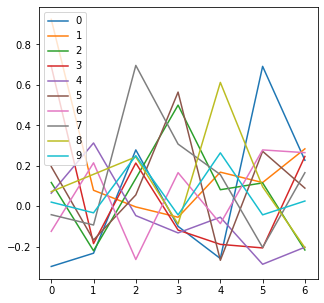

In [9]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

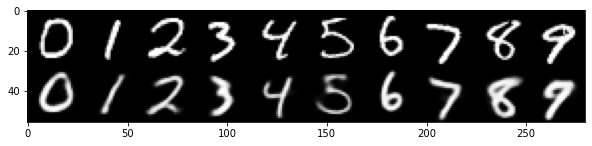

In [10]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [11]:
from XAE.sampler import gaus

exn = 5

In [12]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

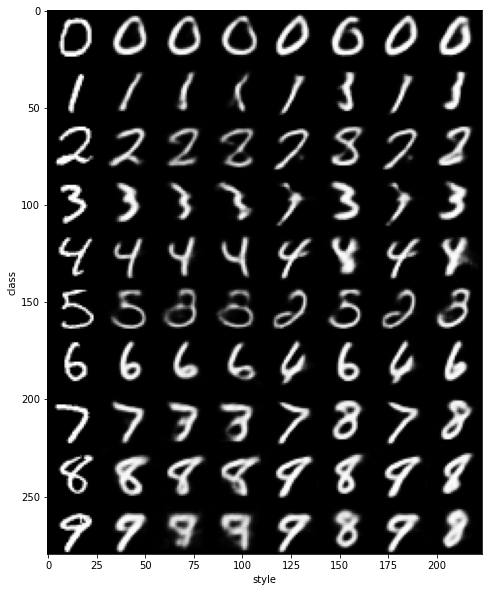

In [13]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [14]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

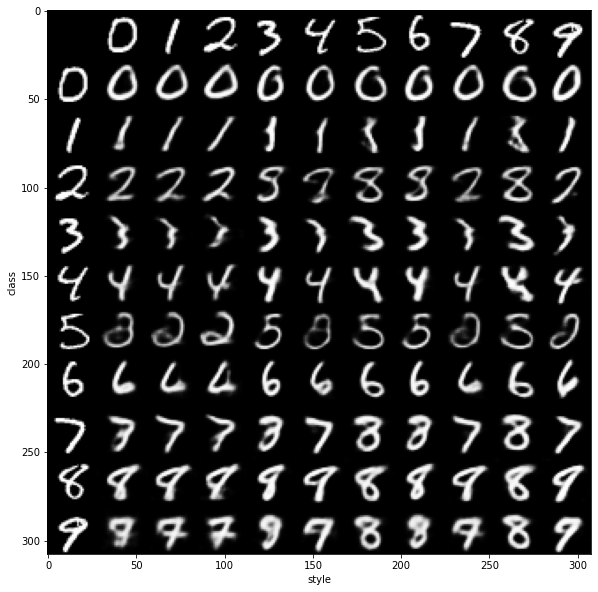

In [15]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()